## Import Libraries

In [11]:
import GetTesouroDiretoData as gtd
import pandas as pd
import matplotlib.pyplot as plt
import DataAnalylis

## Download Tesouro Direto Dataset

In [2]:
# gtd.TesouroDiretoDatasets().download_all_data('TesouroDireto')

In [3]:
operacoes = pd.read_parquet('TesouroDireto_operacoes.parquet')
investidores = pd.read_parquet('TesouroDireto_investidores.parquet')
taxas = pd.read_parquet('TesouroDireto_taxas.parquet')
vendas = pd.read_parquet('TesouroDireto_vendas.parquet')
estoque = pd.read_parquet('TesouroDireto_estoque.parquet')

## Data Analysis

O ciclo atual é: Média


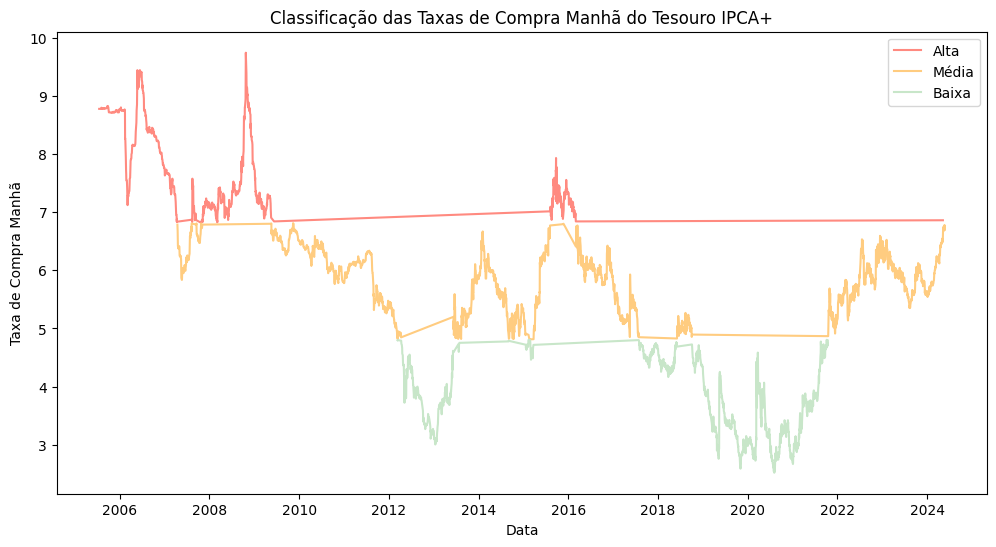

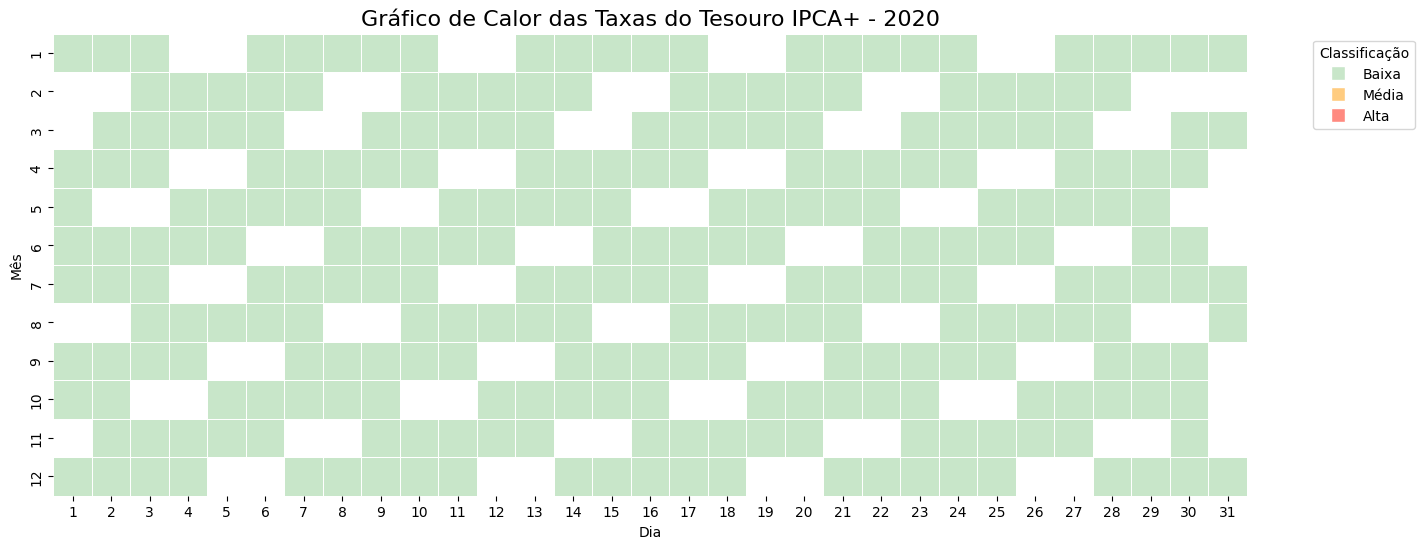

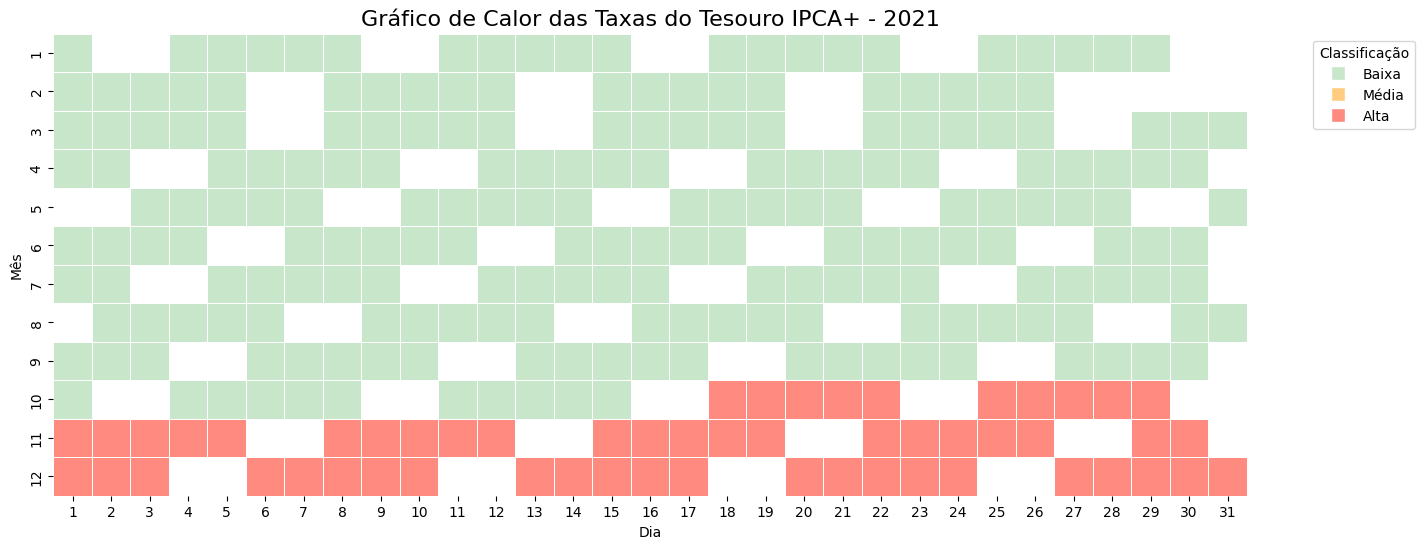

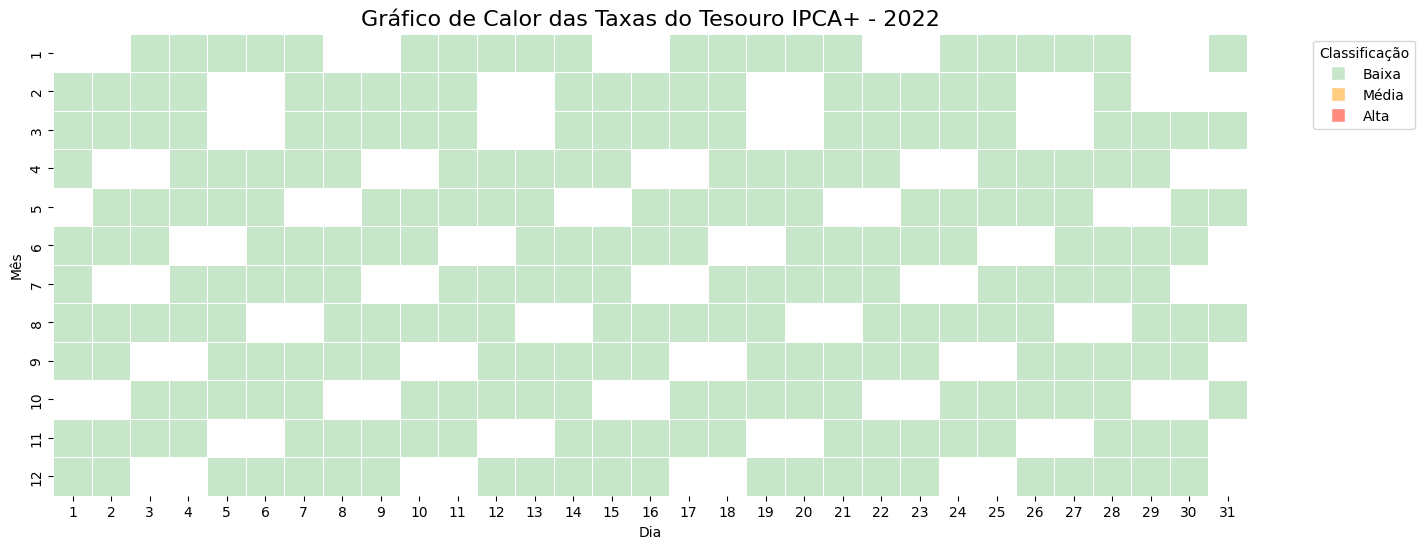

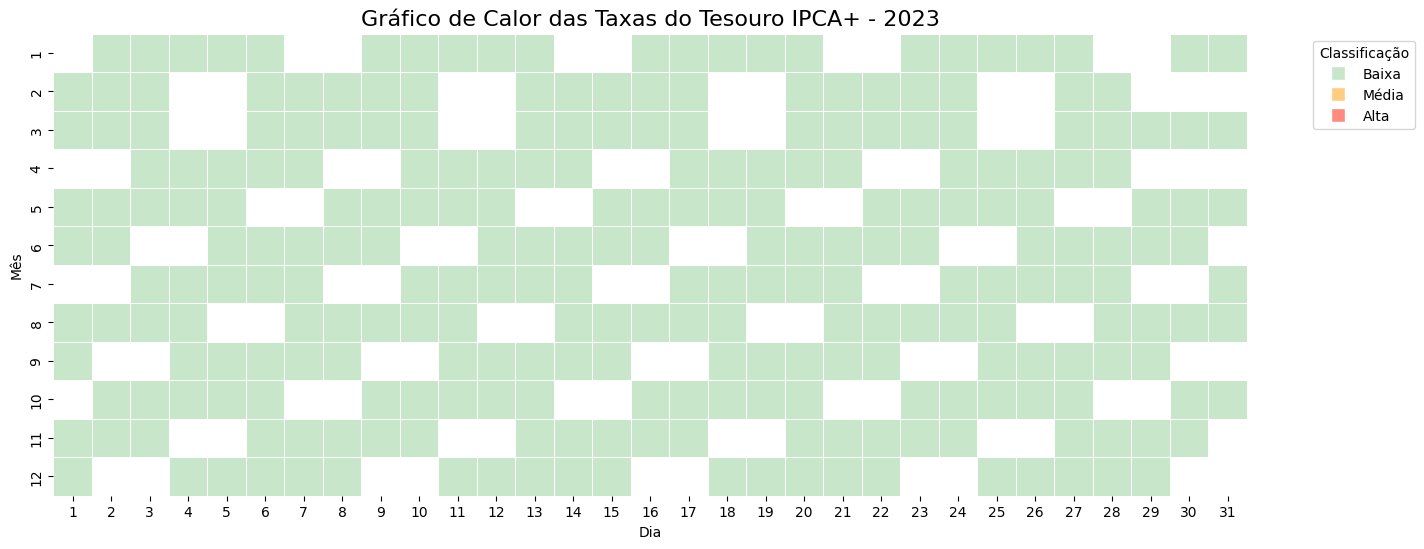

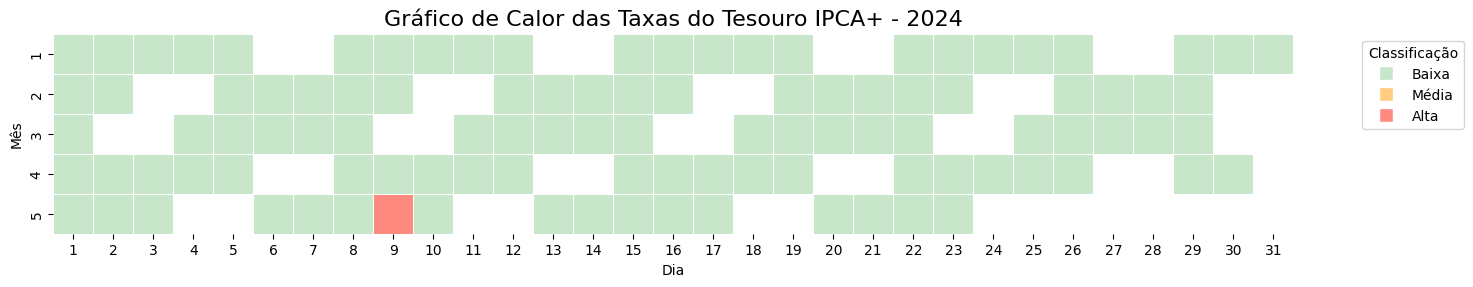

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from typing import Dict

class TreasuryRateClassifier:
    """
    Classe para classificar as taxas de títulos do Tesouro Direto IPCA+ em diferentes ciclos (alta, média, baixa).

    Atributos:
    ----------
    df : pd.DataFrame
        O DataFrame contendo os dados do Tesouro Direto.
    ts : pd.Series
        A série temporal das taxas dos títulos.
    clusters : np.ndarray
        Os agrupamentos das taxas dos títulos.
    labels : Dict[int, str]
        O mapeamento dos índices de cluster para rótulos (alta, média, baixa).
    """

    def __init__(self, df: pd.DataFrame):
        """
        Inicializa a classe TreasuryRateClassifier com o DataFrame fornecido.

        Parâmetros:
        ----------
        df : pd.DataFrame
            O DataFrame contendo os dados do Tesouro Direto.
        """
        self.df = df
        self.ts = self._prepare_time_series()
        self.clusters = None
        self.labels = None
        self.ts_clusters = None

    def _prepare_time_series(self) -> pd.Series:
        """
        Prepara a série temporal para as taxas dos títulos.

        Retorna:
        -------
        pd.Series
            A série temporal preparada das taxas dos títulos.
        """
        self.df['Data Base'] = pd.to_datetime(self.df['Data Base'])
        ts = self.df[self.df['Tipo Titulo'] == 'Tesouro IPCA+']
        ts = ts.groupby('Data Base')['Taxa Compra Manha'].mean()  # Calcula a média diária
        ts = ts.asfreq('B').ffill()  # Frequência 'B' significa dias úteis
        ts = ts[ts >= 0]  # Remover possíveis valores negativos
        return ts

    def normalize_data(self) -> pd.Series:
        """
        Normaliza os dados da série temporal.

        Retorna:
        -------
        pd.Series
            A série temporal normalizada.
        """
        scaler = StandardScaler()
        return scaler.fit_transform(self.ts.values.reshape(-1, 1))

    def apply_clustering(self, n_clusters: int = 3) -> None:
        """
        Aplica o clustering K-means para classificar as taxas dos títulos em ciclos.

        Parâmetros:
        ----------
        n_clusters : int, opcional
            O número de clusters para o K-means (o padrão é 3).
        """
        ts_normalized = self.normalize_data()
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        self.clusters = kmeans.fit_predict(ts_normalized)

    def label_clusters(self) -> None:
        """
        Rotula os clusters como 'alta', 'média' e 'baixa' com base em seus valores médios.
        """
        ts_clusters = pd.DataFrame(self.ts)
        ts_clusters['Cluster'] = self.clusters
        cluster_means = ts_clusters.groupby('Cluster')['Taxa Compra Manha'].mean().sort_values()
        self.labels = {cluster_means.index[0]: 'Baixa', cluster_means.index[1]: 'Média', cluster_means.index[2]: 'Alta'}
        ts_clusters['Label'] = ts_clusters['Cluster'].map(self.labels)
        self.ts_clusters = ts_clusters

    def classify_current_cycle(self) -> str:
        """
        Classifica o ciclo atual das taxas dos títulos.

        Retorna:
        -------
        str
            O rótulo do ciclo atual (alta, média, baixa).
        """
        current_label = self.ts_clusters['Label'].iloc[-1]
        return current_label

    def plot_classification(self) -> None:
        """
        Plota as taxas dos títulos classificadas, conectando os segmentos de diferentes classificações corretamente.
        """
        plt.figure(figsize=(12, 6))
        colors = {'Alta': '#ff8a80', 'Média': '#ffcc80', 'Baixa': '#c8e6c9'}
        for label in self.ts_clusters['Label'].unique():
            subset = self.ts_clusters[self.ts_clusters['Label'] == label]
            plt.plot(subset.index, subset['Taxa Compra Manha'], label=label, color=colors[label])

        plt.title('Classificação das Taxas de Compra Manhã do Tesouro IPCA+')
        plt.xlabel('Data')
        plt.ylabel('Taxa de Compra Manhã')
        plt.legend()
        plt.show()

    def plot_github_style(self) -> None:
        """
        Plota gráficos de calor no estilo GitHub das taxas dos títulos classificadas para os últimos cinco anos.
        """
        recent_data = self.ts_clusters[self.ts_clusters.index >= (self.ts_clusters.index.max() - pd.DateOffset(years=5))].copy()

        # Mapeia os rótulos para cores
        label_colors = {'Alta': 3, 'Média': 2, 'Baixa': 1}
        recent_data['Color'] = recent_data['Label'].map(label_colors)

        # Define a paleta de cores
        palette = {1: '#c8e6c9', 2: '#ffcc80', 3: '#ff8a80'}  # Verde pastel, laranja pastel, vermelho pastel
        years = sorted(recent_data['Color'].index.year.unique())[-5:]

        for year in years:
            yearly_data = recent_data[recent_data.index.year == year].copy()
            yearly_data.loc[:, 'Mês'] = yearly_data.index.month
            yearly_data.loc[:, 'Dia'] = yearly_data.index.day

            heatmap_data = yearly_data.pivot_table(index='Mês', columns='Dia', values='Color', aggfunc='mean')

            plt.figure(figsize=(16, 6))
            sns.heatmap(heatmap_data, linewidths=0.5, cmap=sns.color_palette([palette[1], palette[2], palette[3]]), linecolor='white', square=True, cbar=False)
            plt.title(f'Gráfico de Calor das Taxas do Tesouro IPCA+ - {year}', fontsize=16)
            plt.xlabel('Dia')
            plt.ylabel('Mês')
            # Adicionando uma legenda de cores
            handles = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=palette[i], markersize=10) for i in palette]
            labels = ['Baixa', 'Média', 'Alta']
            plt.legend(handles, labels, title='Classificação', bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.show()

# Exemplo de uso
# Supondo que 'taxas' seja um DataFrame carregado
classifier = TreasuryRateClassifier(taxas)
classifier.apply_clustering()
classifier.label_clusters()
current_cycle = classifier.classify_current_cycle()
print(f'O ciclo atual é: {current_cycle}')
classifier.plot_classification()
classifier.plot_github_style()